Process data for use in chapter plotting notebooks

In [1]:
import pathlib
import copy
import warnings
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
from pyspectral import blackbody

from tobac_flow import io, abi, glm, nexrad
from tobac_flow.dataset import create_new_goes_ds
from tobac_flow.utils import get_datetime_from_coord
from pyLRT import RadTran, get_lrt_folder

ncdump [-c|-h] [-v ...] [[-b|-f] [c|f]] [-l len] [-n name] [-p n[,n]] [-k] [-x] [-s] [-t|-i] [-g ...] [-w] [-F] [-Ln] file
  [-c]             Coordinate variable data and header information
  [-h]             Header information only, no data
  [-v var1[,...]]  Data for variable(s) <var1>,... only
  [-b [c|f]]       Brief annotations for C or Fortran indices in data
  [-f [c|f]]       Full annotations for C or Fortran indices in data
  [-l len]         Line length maximum in data section (default 80)
  [-n name]        Name for netCDF (default derived from file name)
  [-p n[,n]]       Display floating-point values with less precision
  [-k]             Output kind of netCDF file
  [-s]             Output special (virtual) attributes
  [-t]             Output time data as date-time strings
  [-i]             Output time data as date-time strings with ISO-8601 'T' separator
  [-g grp1[,...]]  Data and metadata for group(s) <grp1>,... only
  [-w]             With client-side caching of va


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [8]:
# Filter some warnings because pyart doesn't work nicely with notebooks
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning
)

warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)

warnings.filterwarnings(
    action='ignore',
    category=FutureWarning
)

In [2]:
save_path = pathlib.Path("../data")
if not save_path.exists():
    save_path.mkdir()

data_path = pathlib.Path('/Users/jonesw/python/tobac-flow/data')
if not data_path.exists():
    data_path.mkdir()

In [3]:
# Load files
goes_data_path = data_path / "GOES16"
start_date = datetime(2018,6,19,17)
end_date = start_date + timedelta(hours=4)
x0 = 1300
x1 = 1600
y0 = 600
y1 = 900
dates = pd.date_range(start_date, end_date, freq='H', inclusive='left').to_pydatetime()
io_kwargs = {
    'satellite':16,
    'product':'MCMIP',
    'view':'C',
    'mode':[3,4,6],
    'save_dir':goes_data_path,
    'replicate_path':True,
    'check_download':True,
    'n_attempts':1,
    'download_missing':True
}

abi_files = io.find_abi_files(
    dates, **io_kwargs
)

abi_dates = [io.get_goes_date(i) for i in abi_files]

print(len(abi_files))

# Load a stack of goes datasets using xarray. Select a region over Northern Florida. 
# (full file size in 1500x2500 pixels)
ds_slice = {'x':slice(x0,x1), 'y':slice(y0,y1)}
goes_ds = xr.open_mfdataset(abi_files, concat_dim='t', combine='nested').isel(ds_slice)
goes_ds

48


<xarray.Dataset>
Dimensions:                                 (t: 48, y: 300, x: 300,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
  * t                                       (t) datetime64[ns] 2018-06-19T17:...
  * y                                       (y) float64 0.09461 ... 0.07787
  * x                                       (x) float64 -0.02853 ... -0.01179
    y_image                                 float32 0.08624
    x_image                                 float32 -0.03136
    band_wavelength_C01                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                      ...
    band_id_C11                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C12                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C13                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C14                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C15                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C16                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (t, y, x) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    DQF_C01                                 (t, y, x) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    CMI_C02                                 (t, y, x) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    DQF_C02                                 (t, y, x) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    CMI_C03                                 (t, y, x) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    DQF_C03                                 (t, y, x) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    ...                                      ...
    mean_brightness_temperature_C16         (t) float64 264.7 264.7 ... 262.7
    std_dev_brightness_temperature_C16      (t) float64 14.76 14.79 ... 17.0
    percent_uncorrectable_GRB_errors        (t) float64 0.0 0.0 0.0 ... 0.0 0.0
    percent_uncorrectable_L0_errors         (t) float64 0.0 0.0 0.0 ... 0.0 0.0
    dynamic_algorithm_input_data_container  (t) int32 -2147483647 ... -214748...
    algorithm_product_version_container     (t) int32 -2147483647 ... -214748...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2018-06-19T17:05:14.0Z
    time_coverage_start:       2018-06-19T17:02:24.6Z
    time_coverage_end:         2018-06-19T17:05:01.9Z
    timeline_id:               ABI Mode 3
    production_data_source:    Realtime
    id:                        a86fc777-4409-4d46-a734-135c87cb4a6f

In [4]:
# Extract fields and load into memory
chapter1_example_ds = create_new_goes_ds(goes_ds)

bt = goes_ds.CMI_C13.to_numpy()
wvd = (goes_ds.CMI_C08 - goes_ds.CMI_C10).to_numpy()
swd = (goes_ds.CMI_C13 - goes_ds.CMI_C15).to_numpy()

chapter1_example_ds["BT"] = xr.DataArray(bt, dims=("t","y","x"))
chapter1_example_ds["WVD"] = xr.DataArray(wvd, dims=("t","y","x"))
chapter1_example_ds["SWD"] = xr.DataArray(swd, dims=("t","y","x"))

In [54]:
rgb = abi.get_abi_rgb(goes_ds, night_IR=True).compute()

In [59]:
chapter1_example_ds["RGB"] = xr.DataArray(rgb, dims=("t","y","x","channel"))

In [11]:
# Get GLM data
# Process new GLM data
glm_files = io.find_glm_files(
    dates, satellite=16, save_dir=goes_data_path, 
    replicate_path=True, check_download=True, n_attempts=1, download_missing=True
)

glm_files = {io.get_goes_date(i):i for i in glm_files}

len(glm_files)

719

In [12]:
glm_grid = glm.regrid_glm(glm_files, goes_ds, corrected=True)
glm_grid

<xarray.DataArray (t: 48, y: 300, x: 300)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * t        (t) datetime64[ns] 2018-06-19T17:03:43.273992960 ... 2018-06-19T...
  * y        (y) float64 0.09461 0.09456 0.0945 ... 0.07798 0.07792 0.07787
  * x        (x) float64 -0.02853 -0.02848 -0.02842 ... -0.01184 -0.01179

In [13]:
chapter1_example_ds["glm_grid"] = xr.DataArray(glm_grid, dims=("t","y","x"))

In [14]:
# Get flash point locations
h = goes_ds.goes_imager_projection.perspective_point_height
glm_xy = [
    [np.concatenate(locs)*h for locs in zip(
        *[
            glm.get_uncorrected_glm_x_y(glm_files[ft], goes_ds) 
            for ft in glm_files 
            if ft >= date - timedelta(seconds=150) and ft < date + timedelta(seconds=150)
        ]
    )]
    for date in get_datetime_from_coord(goes_ds.t)
]

In [33]:
glm_flash_t = np.repeat(goes_ds.t.to_numpy(), [len(xy[0]) for xy in glm_xy])
glm_flash_x = np.concatenate([xy[0] for xy in glm_xy])/h
glm_flash_y = np.concatenate([xy[1] for xy in glm_xy])/h

wh_in_bounds = np.logical_and.reduce([
    glm_flash_x >= goes_ds.x.data.min(),
    glm_flash_x <= goes_ds.x.data.max(),
    glm_flash_y >= goes_ds.y.data.min(),
    glm_flash_y <= goes_ds.y.data.max(),
])

glm_flash_t = glm_flash_t[wh_in_bounds]
glm_flash_x = glm_flash_x[wh_in_bounds]
glm_flash_y = glm_flash_y[wh_in_bounds]

chapter1_example_ds["glm_flash_t"] = xr.DataArray(glm_flash_t, dims=("glm_flash",))
chapter1_example_ds["glm_flash_x"] = xr.DataArray(glm_flash_x, dims=("glm_flash",))
chapter1_example_ds["glm_flash_y"] = xr.DataArray(glm_flash_y, dims=("glm_flash",))

In [35]:
nexrad_data_path = data_path / 'nexrad_l2'
print('Finding NEXRAD data')
nexrad_sites = nexrad.filter_nexrad_sites(goes_ds,extend=0.001)
print("Number of sites in bound: %d" % len(nexrad_sites))
nexrad_files = sum([
    sum([
        io.find_nexrad_files(date, site, save_dir=nexrad_data_path, download_missing=True) 
        for site in nexrad_sites
    ], [])
    for date in dates
], [])
# Regrid nexrad - note that this is a lengthly operation, expect it to take ~1 hour for the example here
ref_grid, ref_mask = nexrad.regrid_nexrad(nexrad_files, goes_ds, min_alt=2500)


Finding NEXRAD data
Number of sites in bound: 12
2023-06-03 22:34:55.392297 /Users/jonesw/python/tobac-flow/data/nexrad_l2/2018/06/19/KCLX/NWS_NEXRAD_NXL2DPBL_KCLX_20180619170000_20180619175959.tar
2023-06-03 22:38:02.879504 /Users/jonesw/python/tobac-flow/data/nexrad_l2/2018/06/19/KFFC/NWS_NEXRAD_NXL2DPBL_KFFC_20180619170000_20180619175959.tar
2023-06-03 22:38:52.326702 /Users/jonesw/python/tobac-flow/data/nexrad_l2/2018/06/19/KJGX/NWS_NEXRAD_NXL2DPBL_KJGX_20180619170000_20180619175959.tar
2023-06-03 22:40:08.292089 /Users/jonesw/python/tobac-flow/data/nexrad_l2/2018/06/19/KJAX/NWS_NEXRAD_NXL2DPBL_KJAX_20180619170000_20180619175959.tar
2023-06-03 22:41:06.538450 /Users/jonesw/python/tobac-flow/data/nexrad_l2/2018/06/19/KMLB/NWS_NEXRAD_NXL2DPBL_KMLB_20180619170000_20180619175959.tar
2023-06-03 22:42:04.925058 /Users/jonesw/python/tobac-flow/data/nexrad_l2/2018/06/19/KTLH/NWS_NEXRAD_NXL2DPBL_KTLH_20180619170000_20180619175959.tar
2023-06-03 22:46:38.956565 /Users/jonesw/python/tobac-flo

/Users/jonesw/Desktop/DCC_PhD_Thesis/src/tobac-flow/src/tobac_flow/nexrad.py:221: RuntimeWarning: invalid value encountered in divide
  ref_grid = ref_total / ref_counts_masked


In [46]:
chapter1_example_ds["nexrad_grid"] = xr.DataArray(ref_grid, dims=("t","y","x"))

In [60]:
chapter1_example_ds

<xarray.Dataset>
Dimensions:                 (t: 48, y: 300, x: 300, glm_flash: 7920, channel: 3)
Coordinates:
  * t                       (t) datetime64[ns] 2018-06-19T17:03:43.273992960 ...
  * y                       (y) float64 0.09461 0.09456 ... 0.07792 0.07787
  * x                       (x) float64 -0.02853 -0.02848 ... -0.01184 -0.01179
    x_image                 float32 -0.03136
    y_image                 float32 0.08624
Dimensions without coordinates: glm_flash, channel
Data variables: (12/13)
    goes_imager_projection  (t) int32 -2147483647 -2147483647 ... -2147483647
    lat                     (y, x) float32 33.57 33.57 33.57 ... 26.68 26.68
    lon                     (y, x) float32 -86.49 -86.46 ... -79.36 -79.34
    area                    (y, x) float32 5.787 5.786 5.785 ... 4.931 4.931
    BT                      (t, y, x) float32 291.4 295.7 296.5 ... 294.6 295.2
    WVD                     (t, y, x) float32 -18.62 -18.4 ... -21.62 -21.88
    ...                      ...
    glm_grid                (t, y, x) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    glm_flash_t             (glm_flash) datetime64[ns] 2018-06-19T17:03:43.27...
    glm_flash_x             (glm_flash) float64 -0.02104 -0.02093 ... -0.02005
    glm_flash_y             (glm_flash) float64 0.08456 0.08476 ... 0.08656
    nexrad_grid             (t, y, x) float64 -33.0 -33.0 -33.0 ... -33.0 -33.0
    RGB                     (t, y, x, channel) float32 0.5802 0.614 ... 0.3201

In [61]:
chapter1_example_ds.to_netcdf(save_path / "chapter_1_example_data.nc")

/var/folders/40/kfr98p0j7n30fjp2n4ljjqbh0000gr/T/ipykernel_7245/4029791081.py:1: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  chapter2_example_ds.to_netcdf(save_path / "chapter_2_example_data.nc")
/var/folders/40/kfr98p0j7n30fjp2n4ljjqbh0000gr/T/ipykernel_7245/4029791081.py:1: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  chapter2_example_ds.to_netcdf(save_path / "chapter_2_example_data.nc")


LibRadTran data for theory section

In [62]:
LIBRADTRAN_FOLDER = get_lrt_folder()

In [63]:
# Get radiances for a range of cloud heights
tlrt = RadTran(LIBRADTRAN_FOLDER)
tlrt.options['rte_solver'] = 'disort'
tlrt.options['source'] = 'thermal'
tlrt.options['wavelength'] = '3000 15000'
tlrt.options['output_user'] = 'lambda edir eup uu'
tlrt.options['zout'] = '0 TOA'
tlrt.options['albedo'] = '0.5'
tlrt.options['umu'] = '-1.0 1.0'
tlrt.options['quiet'] = ''
tlrt.options['sza'] = '0'
tlrt.options['mol_abs_param'] = 'reptran fine'
tlrt.options['atmosphere_file'] = f'{LIBRADTRAN_FOLDER}/data/atmmod/afglt.dat'


In [64]:
tdata, _ = tlrt.run(verbose=True)
tlist = [tdata]

for i in range(1,16):
    print(f"Running with cloud at {i}km")
    tlrt_cld = copy.deepcopy(tlrt)
    tlrt_cld.add_cloud(height=i, base_height=0, lwc=1000, re=15)
    
    tcdata, _ = tlrt_cld.run(verbose=True)
    tlist.append(tcdata)

Running with cloud at 1km
Running with cloud at 2km
Running with cloud at 3km
Running with cloud at 4km
Running with cloud at 5km
Running with cloud at 6km
Running with cloud at 7km
Running with cloud at 8km
Running with cloud at 9km
Running with cloud at 10km
Running with cloud at 11km
Running with cloud at 12km
Running with cloud at 13km
Running with cloud at 14km
Running with cloud at 15km


In [65]:
chapter1_theory_ds = xr.Dataset()

wavelengths = tdata[1::2, 0]/1e9
radiances = []
brightness_temperature = []

for tdata in tlist:
    radiances.append(tdata[1::2, 2]/np.pi/100/wavelengths[-1]**2)
    brightness_temperature.append(
        blackbody.blackbody_rad2temp(wavelengths[-1].reshape(1,-1), radiances[-1].reshape(1,-1))
    )

radiances = np.stack(radiances)
brightness_temperature = np.stack(brightness_temperature)

dims = ("height", "wavelength")
coords = {"height": np.arange(16), "wavelength":wavelengths}

chapter1_theory_ds["cloud_height_radiances"] = xr.DataArray(
    radiances, dims=dims, coords=coords
)
chapter1_theory_ds["cloud_height_brightness_temperature"] = xr.DataArray(
    brightness_temperature, dims=dims, coords=coords
)


In [66]:
odlist = np.arange(0.125,1,0.125).tolist() + np.arange(1,2,0.25).tolist() + np.arange(2,5,0.5).tolist() + np.arange(5,11,1).tolist()

ilrt = copy.deepcopy(tlrt)

ilist = []

idata, _ = ilrt.run(verbose=True, print_input=True)

ilist.append(idata)

for od in odlist:
    print(f"Running with cloud at {od} optical depth")
    ilrt.add_cloud(type="ice", height=14, thickness=2, od=od, re=20)

    icdata, _ = ilrt.run(verbose=True)
    ilist.append(icdata)


rte_solver disort
source thermal
wavelength 3000 15000
output_user lambda edir eup uu
zout 0 TOA
albedo 0.5
umu -1.0 1.0
sza 0
mol_abs_param reptran fine
atmosphere_file /Users/jonesw/libRadtran-2.0.4/data/atmmod/afglt.dat
verbose 

Running with cloud at 0.125 optical depth
Running with cloud at 0.25 optical depth
Running with cloud at 0.375 optical depth
Running with cloud at 0.5 optical depth
Running with cloud at 0.625 optical depth
Running with cloud at 0.75 optical depth
Running with cloud at 0.875 optical depth
Running with cloud at 1.0 optical depth
Running with cloud at 1.25 optical depth
Running with cloud at 1.5 optical depth
Running with cloud at 1.75 optical depth
Running with cloud at 2.0 optical depth
Running with cloud at 2.5 optical depth
Running with cloud at 3.0 optical depth
Running with cloud at 3.5 optical depth
Running with cloud at 4.0 optical depth
Running with cloud at 4.5 optical depth
Running with cloud at 5 optical depth
Running with cloud at 6 optical depth

In [68]:
radiances = []
brightness_temperature = []

for idata in ilist:
    radiances.append(idata[1::2, 2]/np.pi/100/wavelengths[-1]**2)
    brightness_temperature.append(
        blackbody.blackbody_rad2temp(wavelengths[-1].reshape(1,-1), radiances[-1].reshape(1,-1))
    )

radiances = np.stack(radiances)
brightness_temperature = np.stack(brightness_temperature)

dims = ("optical_depth", "wavelength")
coords = {"optical_depth": [0]+odlist, "wavelength":wavelengths}

chapter1_theory_ds["cloud_od_radiances"] = xr.DataArray(
    radiances, dims=dims, coords=coords
)
chapter1_theory_ds["cloud_od_brightness_temperature"] = xr.DataArray(
    brightness_temperature, dims=dims, coords=coords
)

In [98]:
abi_vertical_weighting = np.array([
    [32.3,0,0,0,0],
    [35.7,0,0,0,0],
    [39.3,0,0,0,0],
    [43.1,0,0,0,0],
    [47.2,0,0,0,0],
    [51.5,0,0,0,0],
    [56.1,0,0,0,0],
    [61,0,0,0,0],
    [66.1,0,0,0,0],
    [71.5,0,0,0,0],
    [77.2,0,0,0,0],
    [83.2,0.1,0,0,0],
    [89.5,0.1,0,0,0],
    [96.1,0.1,0,0,0],
    [103,0.1,0,0,0],
    [110.2,0.1,0,0,0],
    [125.6,0.1,0,0,0],
    [133.8,0.1,0,0,0],
    [142.4,0.1,0,0,0],
    [151.3,0.1,0.1,0,0],
    [160.5,0.2,0.1,0,0],
    [170.1,0.2,0.1,0,0],
    [180,0.2,0.1,0,0],
    [190.3,0.2,0.1,0,0],
    [201,0.3,0.1,0,0],
    [212,0.3,0.1,0,0],
    [223.4,0.4,0.1,0,0],
    [235.2,0.4,0.1,0,0],
    [247.4,0.4,0.2,0,0],
    [260,0.5,0.2,0,0],
    [272.9,0.5,0.2,0,0],
    [286.3,0.6,0.2,0,0],
    [300,0.6,0.2,0,0],
    [314.1,0.7,0.3,0,0],
    [328.7,0.8,0.3,0,0],
    [343.6,0.9,0.4,0,0],
    [359,1.5,0.5,0,0],
    [374.7,2.2,0.8,0,0],
    [390,2.4,1.1,0,0],
    [407.5,2.1,1.2,0,0.1],
    [424.5,1.7,1.3,0,0.1],
    [441.9,1.3,1.5,0,0.1],
    [459.7,1,1.7,0.1,0.2],
    [478,0.6,1.8,0.1,0.2],
    [496.6,0.3,1.6,0.1,0.2],
    [515.7,0.2,1.4,0.1,0.2],
    [535.2,0.1,1.4,0.1,0.3],
    [555.2,0,1.3,0.1,0.3],
    [575.5,0,1.2,0.2,0.4],
    [596.3,0,1,0.2,0.5],
    [617.5,0,0.8,0.3,0.6],
    [639.1,0,0.7,0.3,0.6],
    [661.2,0,0.5,0.3,0.6],
    [683.7,0,0.3,0.3,0.6],
    [706.6,0,0.3,0.3,0.6],
    [729.9,0,0.2,0.3,0.6],
    [753.6,0,0.2,0.5,0.8],
    [777.8,0,0.1,0.6,1],
    [802.4,0,0.1,0.7,1.2],
    [827.4,0,0,0.9,1.4],
    [852.8,0,0,1,1.6],
    [878.6,0,0,1.2,1.7],
    [904.9,0,0,1.3,1.9],
    [931.5,0,0,1.5,2],
    [958.6,0,0,1.7,2],
    [986.1,0,0,1.9,2.1],
    [1013.9,0,0,2.1,2.1],
    [1042.2,0,0,2.2,2]
]).T

In [100]:
pressures = abi_vertical_weighting[0]
abi_vertical_weighting = abi_vertical_weighting[1:]
abi_vertical_weighting = abi_vertical_weighting/abi_vertical_weighting.max(1)[:,np.newaxis]

In [104]:
abi_vertical_weighting.shape

(4, 68)

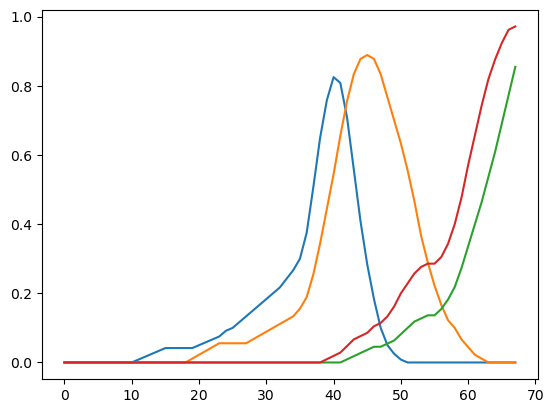

In [111]:
chapter1_theory_ds["vertical_weighting_functions"] = xr.DataArray(abi_vertical_weighting, coords={"pressure":pressures}, dims=("channel", "pressure")).rolling({"pressure":5}, min_periods=1).mean()

In [69]:
chapter1_theory_ds

<xarray.Dataset>
Dimensions:                              (height: 16, wavelength: 2668,
                                          optical_depth: 24)
Coordinates:
  * height                               (height) int64 0 1 2 3 ... 12 13 14 15
  * wavelength                           (wavelength) float64 3e-06 ... 1.5e-05
  * optical_depth                        (optical_depth) float64 0.0 ... 10.0
Data variables:
    cloud_height_radiances               (height, wavelength) float64 1.004e+...
    cloud_height_brightness_temperature  (height, wavelength) float64 80.2 .....
    cloud_od_radiances                   (optical_depth, wavelength) float64 ...
    cloud_od_brightness_temperature      (optical_depth, wavelength) float64 ...

In [70]:
chapter1_theory_ds.to_netcdf(save_path / "chapter_1_theory_data.nc")